In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

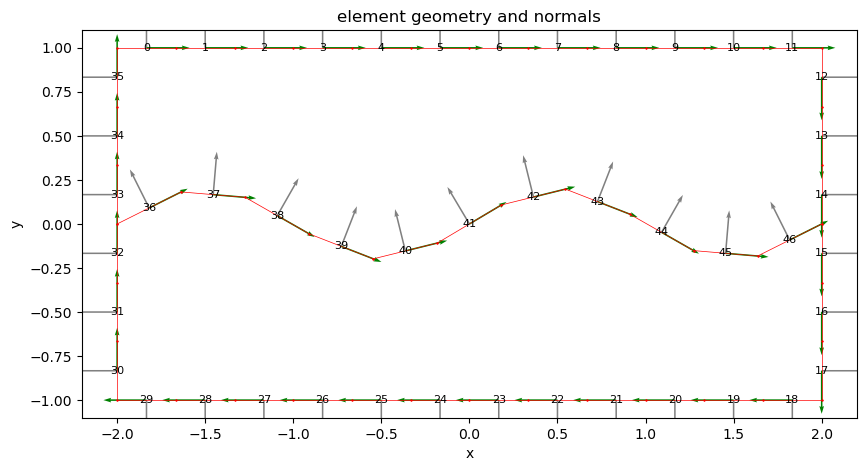

In [9]:
# Elastic parameters
mu = 1
nu = 0.25

# create a box mesh with a sinusoidal fault in the middle
L = 2
H = 1
ngrid = 3
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % 4][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % 4][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])
x = np.hstack(x)
z = np.hstack(z)

x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())


# Create a sinusoidal fault centered around y=0
x = np.linspace(-L,L,int(2*L/H*ngrid))
z = 0.2*H*np.sin(4*np.pi*x/2/L)
x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())

elements = bemcs.standardize_elements(elements)
n_elements = len(elements)
# store element midpoints
elements_midpts = np.zeros((n_elements,2))
for i in range(n_elements):
    elements_midpts[i,0] = 0.5*(elements[i]["x1"]+elements[i]["x2"])
    elements_midpts[i,1] = 0.5*(elements[i]["y1"]+elements[i]["y2"])

plt.figure(figsize=(10,6))
bemcs.plot_element_geometry(elements)
# plt.plot(elements_midpts[:,0],elements_midpts[:,1],'o')
plt.show()

In [12]:
# add labels for top,right,bot,left,interior
# labels = np.zeros((n_elements,5))
class element_labels:
    def __init__(self):
        self.top = None
        self.right = None
        self.bot = None
        self.left = None
        self.interior = None
labels = element_labels()
labels.top = elements_midpts[:,1] == H # top
labels.right = elements_midpts[:,0] == L # right
labels.bot = elements_midpts[:,1] == H # top
labels.left = elements_midpts[:,0] == -L # left


In [ ]:
# unit vector in normal direction
nvec = np.zeros((n_elements,2))
for i in range(n_elements):
    nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))

# patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
x_obs = np.zeros((n_elements,1)) 
y_obs = np.zeros((n_elements,1)) 
for i in range(n_elements):
    x_obs[i,0] = 0.5*(elements[i]["x1"]+elements[i]["x2"]) - nvec[i,0]*1e-16
    y_obs[i,0] = 0.5*(elements[i]["y1"]+elements[i]["y2"]) - nvec[i,1]*1e-16